## Разбиение на train и test

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

import sqlite3
from sklearn.model_selection import train_test_split
from scipy.sparse import lil_matrix, save_npz, load_npz

import json

warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv('user_song_df.csv')

In [3]:
data.drop(['Unnamed: 0', 'track_id'], axis=1, inplace=True)

In [4]:
data.head()

,user_id,song_id,play_count,title,release,artist_name,year,genre,artist_country,artist_city
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAPDEY12A81C210A9,1,Nothing from Nothing,To Die For,Billy Preston,1974,r&b,United States,Houston
1,fd13b9d49c54e00ff413fe3c095ba581c7fc611e,SOAPDEY12A81C210A9,8,Nothing from Nothing,To Die For,Billy Preston,1974,r&b,United States,Houston
2,35752a9e4d917c8fc5da88e90c25adc6b52220b6,SOAPDEY12A81C210A9,1,Nothing from Nothing,To Die For,Billy Preston,1974,r&b,United States,Houston
3,bfe8d6d1e32d9de12c632d68712e7e4a23416e93,SOAPDEY12A81C210A9,1,Nothing from Nothing,To Die For,Billy Preston,1974,r&b,United States,Houston
4,46d3ef1b4f317aba8f0226e937c67ecef9fa2e42,SOAPDEY12A81C210A9,4,Nothing from Nothing,To Die For,Billy Preston,1974,r&b,United States,Houston


In [5]:
data.shape

(45795099, 10)

In [6]:
data = data[(data.year != 0) & (data.genre != 'no_genre') & (data.artist_country != 'No country')]

In [8]:
data.song_id.nunique()

170123

In [9]:
song_count = data.groupby('user_id', as_index=False).agg({'song_id': 'count'})

In [10]:
song_count = song_count[song_count.song_id >= 45]

In [11]:
data = data[data.user_id.isin(song_count.user_id)]

In [12]:
print(f'Пользователей в data: {data.user_id.nunique()}')
print(f'Песен в data: {data.song_id.nunique()}')

Пользователей в data: 166915
Песен в data: 162425


In [12]:
train, test = train_test_split(data, 
                               stratify=data['user_id'], 
                               test_size=0.20, 
                               random_state=17)

print(f'Размер train: {len(train)}')
print(f'Размер test: {len(test)}')

Размер train: 11513674
Размер test: 2878419


Посмотрим, сколько всего есть уникальных пользователей и песен в train и test

In [13]:
print(f'Пользователей в train: {train.user_id.nunique()}')
print(f'Песен в train: {train.song_id.nunique()}', end='\n\n')

print(f'Пользователей в test: {test.user_id.nunique()}')
print(f'Песен в test: {test.song_id.nunique()}', end='\n\n')

Пользователей в train: 166915
Песен в train: 158630

Пользователей в test: 166915
Песен в test: 125057



Посмотрим на распределение числа прослушиваний песен для train и test

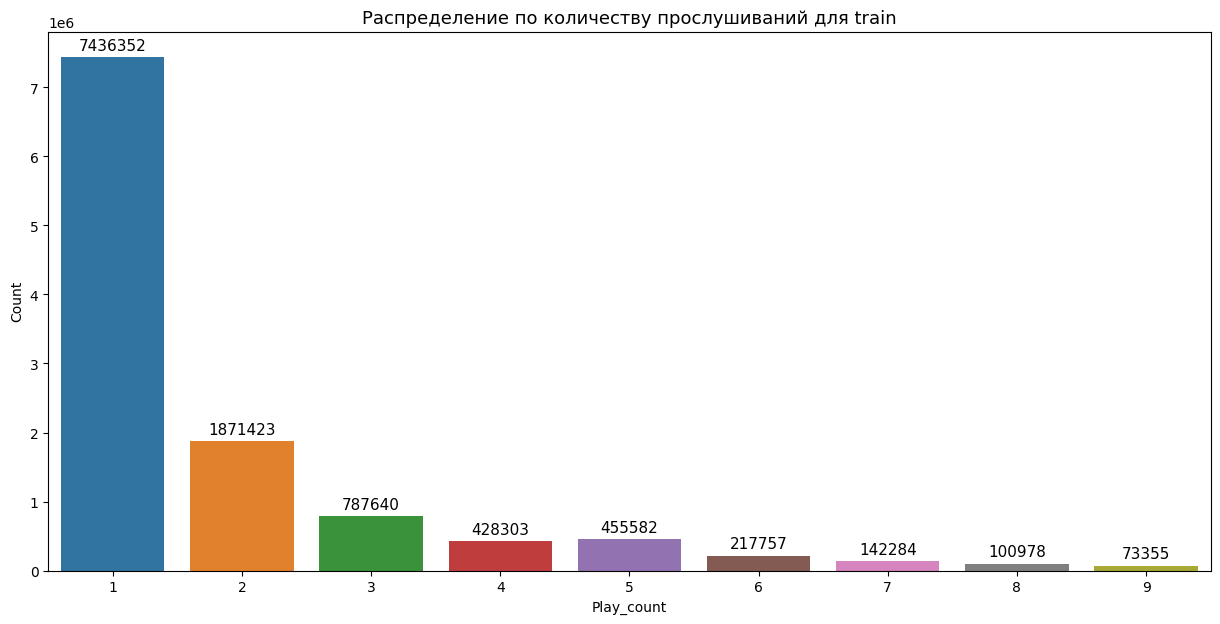

In [20]:
fig = plt.figure(figsize = (15, 7))

ax = sns.countplot(x='play_count', data=train);

for rect in ax.patches:
    ax.text(rect.get_x() + rect.get_width() / 2, rect.get_height() + 100000, 
            int(rect.get_height()), horizontalalignment='center', fontsize = 11)

plt.title('Распределение по количеству прослушиваний для train', fontsize=13);
plt.ylabel('Count', fontsize=10);
plt.xlabel('Play_count',  fontsize=10);

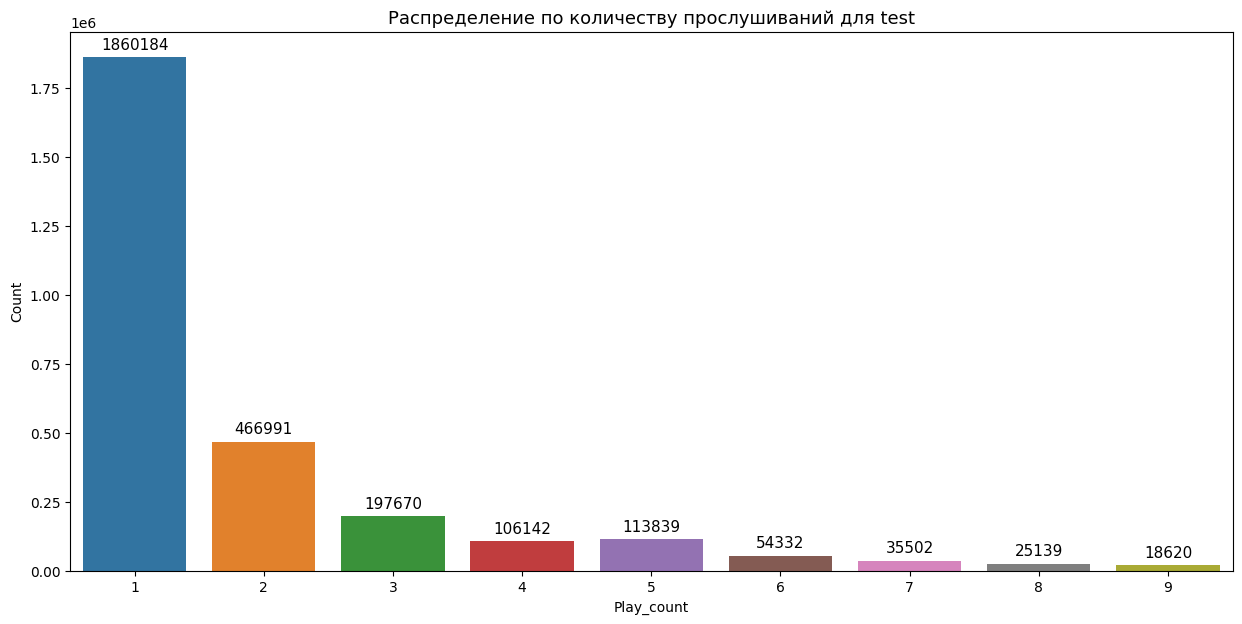

In [22]:
fig = plt.figure(figsize = (15, 7))

ax = sns.countplot(x='play_count', data=test);

for rect in ax.patches:
    ax.text(rect.get_x() + rect.get_width() / 2, rect.get_height() + 30000, 
            int(rect.get_height()), horizontalalignment='center', fontsize = 11)

plt.title('Распределение по количеству прослушиваний для test', fontsize=13);
plt.ylabel('Count', fontsize=10);
plt.xlabel('Play_count',  fontsize=10);

Распределение после разбиения осталось неизменным

In [16]:
train.to_csv('train.csv', index=False)
test.to_csv('test.csv', index=False)

## SQL

Так как таблицы получились достаточно большими, будем хранить их, используя базу данных SQLite.

In [17]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train.head()

,user_id,song_id,play_count,title,release,artist_name,year,genre,artist_country,artist_city
0,cf35f2d9f1fcf1e328381c6b405ed5486c9210c3,SOKYRPO12A8C135E20,1,GNG BNG,Los Angeles,Flying Lotus,2008,electronic,United States,Los Angeles
1,a626e97535a9288014b3fd5720e2bd89306946dc,SOUEAAS12A8C133106,1,Let It Fall,Youth Novels,Lykke Li,2008,pop,Sweden,Ystad
2,e560f55f11094c6775afadeea027e6400400617b,SOZYPRF12A6310F1B4,1,Aerodynamic (Slum Village Remix),Daft Club,Daft Punk,2001,electronic,France,Paris
3,b362bbc8f7ee8fb9c1804cc873d36651bff23b1e,SOKBGLX12A58A806E8,1,Lighthouse,Some Kind Of Zombie,Audio Adrenaline,1997,gospel & religious,United States,Grayson
4,62c1a30fb2665ecfd048fbd847fd4d6f52e6f132,SONIEQI12AF72A9822,1,Atrévete te te,Calle 13 (Explicit Version),Calle 13,2005,reggaeton,Puerto Rico,Trujillo Alto


In [39]:
conn = sqlite3.connect('music_rate.db')

In [40]:
cursor = conn.cursor()

In [26]:
data.to_sql(name='data', con=conn)

14392093

In [27]:
train.to_sql(name='train', con=conn)

11513674

In [28]:
test.to_sql(name='test', con=conn)

2878419

In [45]:
def make_sparse_matrix(table_name: str, data: str):
    
    users_sql = f"""
        SELECT DISTINCT user_id
        FROM {data}
        ORDER BY user_id
    """
    cursor.execute(users_sql)

    user_to_row = {}
    for row_id, (user_id,) in enumerate(cursor):
        user_to_row[user_id] = row_id
    
    song_sql = f"""
        SELECT DISTINCT song_id
        FROM {data}
        ORDER BY song_id
    """
    cursor.execute(song_sql)

    song_to_col = {}
    for col_id, (song_id,) in enumerate(cursor):
        song_to_col[song_id] = col_id
    
    query = f"""
        SELECT user_id, song_id, play_count
        FROM {table_name}
    """
    cursor.execute(query)
    
    matrix = lil_matrix((len(user_to_row), len(song_to_col)))
    
    # заполняем матрицу
    for user_id, song_id, play_count in cursor:
        row_id = user_to_row.get(user_id)
        col_id = song_to_col.get(song_id)
        matrix[row_id, col_id] = play_count
        
    return matrix, user_to_row, song_to_col

In [30]:
train_sparse_matrix, users, songs = make_sparse_matrix('train', 'data')
test_sparse_matrix, _, _ = make_sparse_matrix('test', 'data')

In [31]:
train_sparse_matrix

<166915x162425 sparse matrix of type '<class 'numpy.float64'>'
	with 11513674 stored elements in List of Lists format>

In [32]:
test_sparse_matrix

<166915x162425 sparse matrix of type '<class 'numpy.float64'>'
	with 2878419 stored elements in List of Lists format>

### Сохраним полученные матрицы

In [33]:
save_npz('train_sparse_matrix.npz', train_sparse_matrix.tocoo())
save_npz('test_sparse_matrix.npz', test_sparse_matrix.tocoo())

# Сохраним также словари users и songs, 
# чтобы иметь возможность сопоставить индексы в sparse матрице и в нашей таблице

with open('users_id_for_sparse.txt', 'w') as u:
    json.dump(users, u)
    
with open('songs_id_for_sparse.txt', 'w') as s:
    json.dump(songs, s)

In [ ]:
# train_sparse = load_npz('train_sparse_matrix.npz')
# train_sparse

### Уменьшим датасет в 10 раз для более быстрого обучения на тестовых итерациях обучения 

In [25]:
users_10k = data.groupby('user_id', as_index=False).agg({'song_id': 'count'})\
                .rename(columns={'song_id': 'song_count'})\
                .sample(10000)
users_10k.head()

,user_id,song_count
62344,5fca08a8cbf7eed0d41b3713aa038eb137bcc569,51
158042,f26f5121517520b0261daa9dd9ca5a290940bd94,53
143459,dc24930d7a53f0d4f7b64ab49c3aeab692c84e12,102
61995,5f3ba203f9c8b1bcd8e351067078b1f40825ff6d,79
103242,9e8fc5d9aa69b0cdf7085a2885b7b25b441d2b68,59


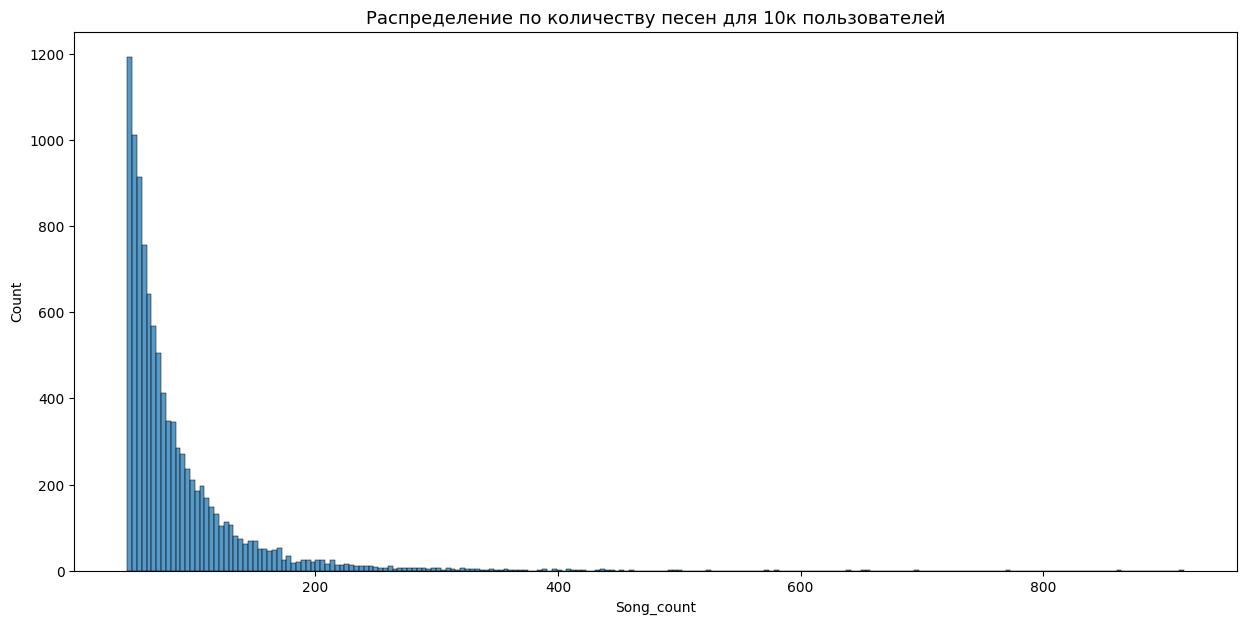

In [26]:
fig = plt.figure(figsize = (15, 7))

ax = sns.histplot(x='song_count', data=users_10k);

plt.title('Распределение по количеству песен для 10к пользователей', fontsize=13);
plt.ylabel('Count', fontsize=10);
plt.xlabel('Song_count',  fontsize=10);

In [29]:
data_10k = data[data.user_id.isin(users_10k.user_id)]

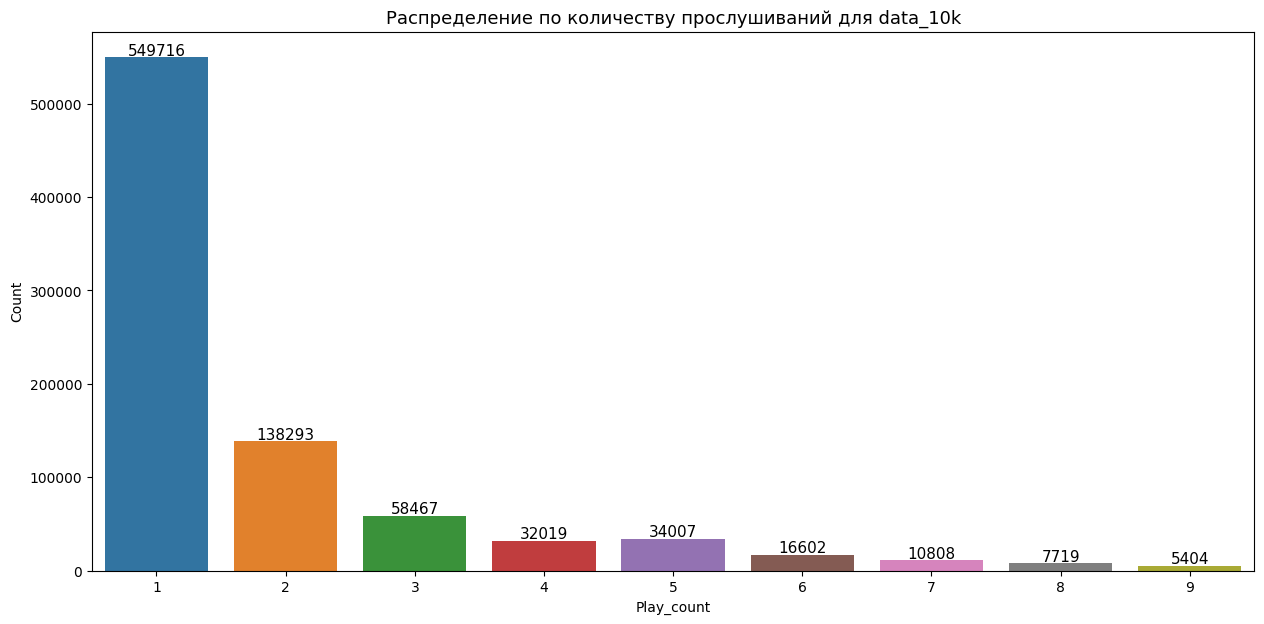

In [31]:
fig = plt.figure(figsize = (15, 7))

ax = sns.countplot(x='play_count', data=data_10k);

for rect in ax.patches:
    ax.text(rect.get_x() + rect.get_width() / 2, rect.get_height() + 2500, 
            int(rect.get_height()), horizontalalignment='center', fontsize = 11)

plt.title('Распределение по количеству прослушиваний для data_10k', fontsize=13);
plt.ylabel('Count', fontsize=10);
plt.xlabel('Play_count',  fontsize=10);

In [32]:
print(f'Пользователей в data_10k: {data_10k.user_id.nunique()}')
print(f'Песен в data_10k: {data_10k.song_id.nunique()}')

Пользователей в data_10k: 10000
Песен в data_10k: 88058


In [33]:
train_10k, test_10k = train_test_split(data_10k, 
                                       stratify=data_10k['user_id'], 
                                       test_size=0.20, 
                                       random_state=17)

print(f'Размер train_10k: {len(train_10k)}')
print(f'Размер test_10k: {len(test_10k)}')

Размер train_10k: 682428
Размер test_10k: 170607


Посмотрим, сколько всего есть уникальных пользователей и песен в train и test

In [34]:
print(f'Пользователей в train_10k: {train_10k.user_id.nunique()}')
print(f'Песен в train_10k: {train_10k.song_id.nunique()}', end='\n\n')

print(f'Пользователей в test_10k: {test_10k.user_id.nunique()}')
print(f'Песен в test_10k: {test_10k.song_id.nunique()}', end='\n\n')

Пользователей в train_10k: 10000
Песен в train_10k: 81458

Пользователей в test_10k: 10000
Песен в test_10k: 45497



Посмотрим на распределение числа прослушиваний песен для train и test

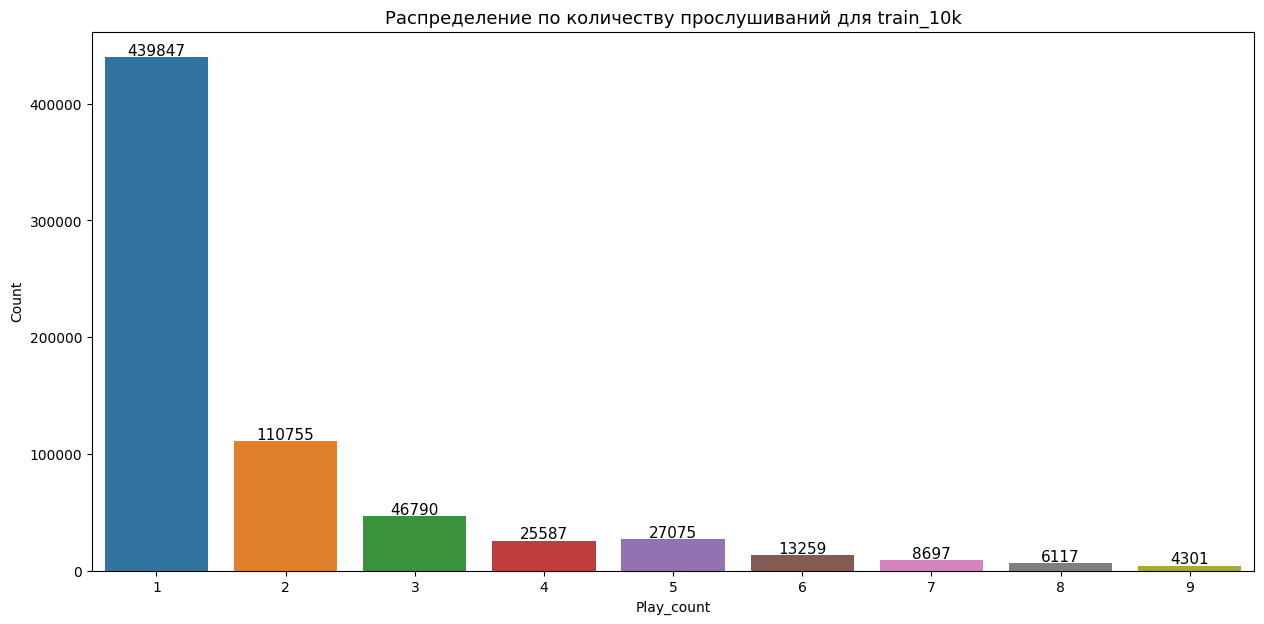

In [36]:
fig = plt.figure(figsize = (15, 7))

ax = sns.countplot(x='play_count', data=train_10k);

for rect in ax.patches:
    ax.text(rect.get_x() + rect.get_width() / 2, rect.get_height() + 1800, 
            int(rect.get_height()), horizontalalignment='center', fontsize = 11)

plt.title('Распределение по количеству прослушиваний для train_10k', fontsize=13);
plt.ylabel('Count', fontsize=10);
plt.xlabel('Play_count',  fontsize=10);

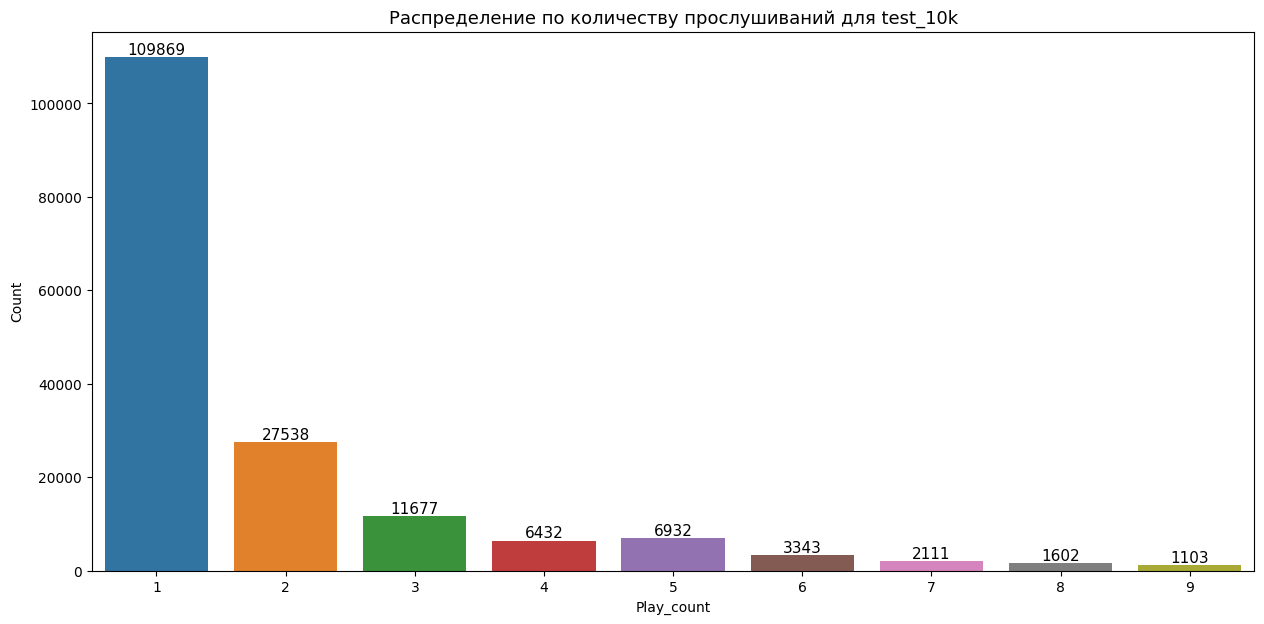

In [37]:
fig = plt.figure(figsize = (15, 7))

ax = sns.countplot(x='play_count', data=test_10k);

for rect in ax.patches:
    ax.text(rect.get_x() + rect.get_width() / 2, rect.get_height() + 600, 
            int(rect.get_height()), horizontalalignment='center', fontsize = 11)

plt.title('Распределение по количеству прослушиваний для test_10k', fontsize=13);
plt.ylabel('Count', fontsize=10);
plt.xlabel('Play_count',  fontsize=10);

Распределение после разбиения осталось неизменным

In [38]:
train_10k.to_csv('train_10k.csv', index=False)
test_10k.to_csv('test_10k.csv', index=False)

In [41]:
data_10k.to_sql(name='data_10k', con=conn, if_exists='replace')

853035

In [42]:
train_10k.to_sql(name='train_10k', con=conn, if_exists='replace')

682428

In [43]:
test_10k.to_sql(name='test_10k', con=conn, if_exists='replace')

170607

In [46]:
train_10k_sparse_matrix, users_10k, songs_10k = make_sparse_matrix('train_10k', 'data_10k')
test_10k_sparse_matrix, _, _ = make_sparse_matrix('test_10k', 'data_10k')

In [47]:
train_10k_sparse_matrix

<10000x88058 sparse matrix of type '<class 'numpy.float64'>'
	with 682428 stored elements in List of Lists format>

In [48]:
test_10k_sparse_matrix

<10000x88058 sparse matrix of type '<class 'numpy.float64'>'
	with 170607 stored elements in List of Lists format>

### Сохраним полученные матрицы

In [49]:
save_npz('train_10k_sparse_matrix.npz', train_10k_sparse_matrix.tocoo())
save_npz('test_10k_sparse_matrix.npz', test_10k_sparse_matrix.tocoo())

# Сохраним также словари users и songs, 
# чтобы иметь возможность сопоставить индексы в sparse матрице и в нашей таблице

with open('users_10k_id_for_sparse.txt', 'w') as u:
    json.dump(users_10k, u)
    
with open('songs_10k_id_for_sparse.txt', 'w') as s:
    json.dump(songs_10k, s)

In [50]:
len(users_10k.keys())

10000